# Intro to Deep Learning
## Authors: Neil Hazra (nhazra@princeton.edu) Alex Zhang (alzhang@princeton.edu) 

Sections:
* What is a neural network
* Building a handwritten digit classifier with Pytorch
* Building a MLP network with Pytorch Modules

## What is a neural network?




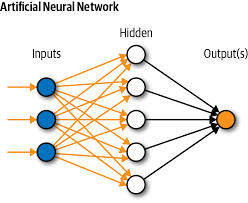

In very broad terms, an artificial neural network, is a network of nodes that each take inputs from the previous layer, perform a simple computation on these inputs, and then relays a signal to nodes in next layer. 

Each neuron itself performs a very simple function on its inputs, but the arrangement of these neurons into complex structures result in much more complex functions. 

Importantly, each neuron is parameterized by a set of coefficients, namely weights and biases, that can be tuned in such a way that the neural network is able to model specific functions with multidimensional inputs and output. (Think of the weights and biases as the m and b parameters in linear regression)


Many neural network frameworks exist that allow for high level and low level design of neural networks (pytorch, tensorflow, theano, caffe etc). My personal favorite is pytorch. Here we are going to make a very basic neural network with low level pytorch by manually creating our variables and defining our neural network with linear algebra operations. 

# Part 1: Building handwritten digit classifier with PyTorch

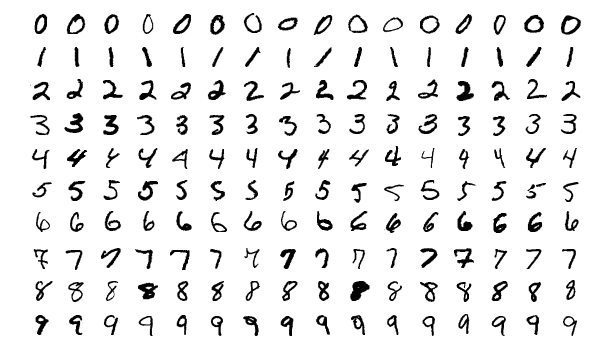

In [ ]:
import torchvision
import numpy as np
import torch
import torch.nn as nn


trainset = torchvision.datasets.MNIST(root='.\data',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='.\data',
                                     train=False,
                                     download=True,
                                     transform=torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=128,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=128,
                                         shuffle=True)

## The perceptron (a single neuron)

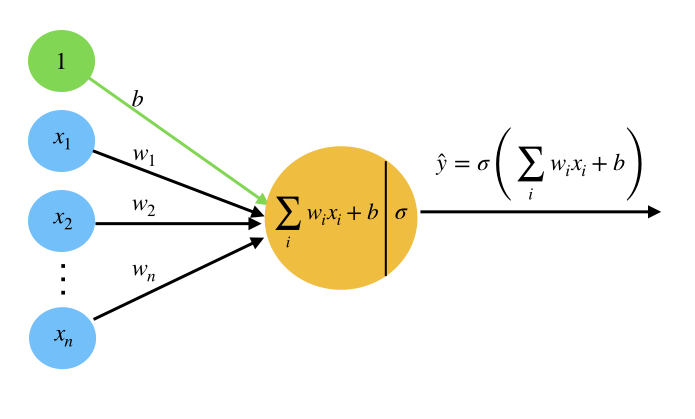

Each neuron first applies a linear transformation to its inputs and then applies a simple non-linear function to get its output. Each neuron can then be described very concisely mathematically: 

$o=\sum_{i=1}^{n}x_{i}w_i + b = w \cdot x + b$

Here $x$ is our input vector, and $w$ is our vector of weights, and b is the bias or offset. **These constants must be learned through training.** Using the dot product we can see that the form of the inner expression is linear. Linearity is beneficial since linear functions are well-studied and well behaved, but unfortunately any composition of linear functions is linear so we need to add non-linearity to get more complex models.

**Activation Function:**
$\phi$ is known as the activation function and is a very simple non-linear scalar function of scalars. We can compose this function with the output of the linear transformation to get a non-linear output:

$y=\phi(\sum_{i=1}^{n}x_{i}w_i + b) = \phi(w \cdot x + b)$

Here are a few commonly used activation functions. 

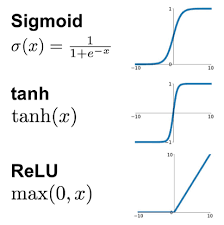

The rough biology parallel is now apparent. Each neuron is inputted some set of signals, the neuron then computes a weigted average of the signals, the neuron then 'fires' a new signal equal to the output of the activation function. 

## The Fully Connected layer

Complex tasks such as image classification, machine translation, or NLP, need to learn significantly more complex relationships than this simple neuron can provide. By organizing these neurons in complex arangements we can achieve this generality. 

The fully connected layer, also called a dense layer, feed forward layer, or vanilla layer, is the most basic organization of neurons in a neural network. It has incredible generality thanks to the universal approximation theorem which states that an arbitrarily wide fully connected layer can approximate arbitrarily well any practical function.

The image below shows a neural network with one dense layer. Visually the arrows represent signals being passed from the output of a previous neuron to the input of a new neuron. (hidden layers refer to any layer that isn't input or output, not necessarily fully connected layers)

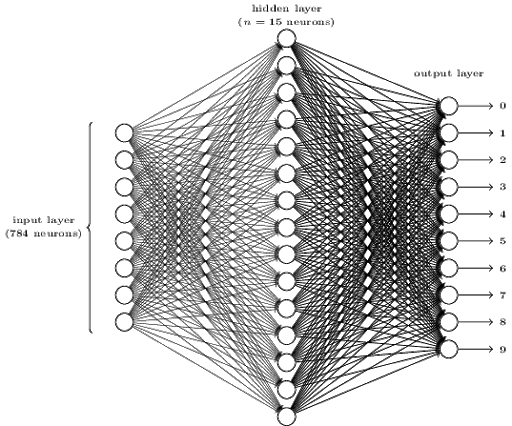

The mathematical definition of a feedforward layer follows directly from the mathematical definition of the perceptron. We just concatenate a bunch of perceptrons into one equation. The weights vector turns into a weights matrix that holds the weights vector of every neuron. Lastly, the scalar bias is now a vector that holds the biases for each neuron. The activation function is then applied elementwise after the linear transformation.

$\vec{y} = \phi(W \vec{x} + \vec{b})$



In [ ]:
class FullyConnectedNeuralNetwork:
    #h = hidden layer dimension = can be anything
    #d = input layer dimension = 784
    #o = output layer dimension = 10
    def __init__(self, h, d, o):
        alpha = 1 / np.sqrt(d)
        '''
        W0 is the weight matrix of the first layer
        b0 is the bias of the first linear layer
        '''
        self.W0 = torch.FloatTensor(h, d).uniform_(-alpha, alpha)
        '''
        Neural networks train through gradient based optimization
        The requires_grad flag lets pytorch know to compute and save the gradient
        (vector of partial derivatives)
        '''
        self.W0.requires_grad = True

        self.b0 = torch.FloatTensor(h).uniform_(-alpha, alpha)
        self.b0.requires_grad = True

        '''
        W1 is the weight matrix of the second layer
        b1 is the bias of the second linear layer
        '''
        self.W1 = torch.FloatTensor(o, h).uniform_(-alpha, alpha)
        self.W1.requires_grad = True
        
        self.b1 = torch.FloatTensor(o).uniform_(-alpha, alpha)
        self.b1.requires_grad = True

    '''
    A list of all the parameters of the models
    '''
    def get_params(self):
        return [self.W0, self.b0, self.W1, self.b1]

    '''
    Define the mathematical definition of the two fully connected layers
    '''
    def forward(self,x):
        firstlayer = nn.functional.relu(torch.matmul(x, self.W0.T) + self.b0)
        output =  nn.functional.log_softmax((torch.matmul(firstlayer, self.W1.T) + self.b1))
        return output

network = FullyConnectedNeuralNetwork(64, 784, 10)

## The Output Layer

The output layer changes the most depending on what the neural network is used for. If you want to use a neural network to do regression, simply place neurons with no-activation function as the outputs. If it is a classification problem more care needs to be taken. 

**Softmax Layer**

The softmax layer basically normalizes each of the neural outputs of the previous layer so that each output is between 0 and 1 and all the outputs sum to 1. In other words, it converts the outputs of the previous layer into a probability distribution. For a classification problem, every output neuron can then be interpreted as the probability of the input belonging to that category. 

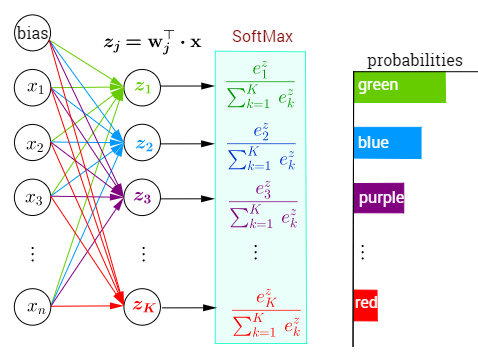

## Training As An Optimization Problem

**Loss Function**

Now that we defined the basic components of a neural network, the next step is to choose the weights and biases of every neuron in every layer so that the neural network learns the correct mapping of inputs and outputs. 

We define a loss function (also called objective function) that quantifies how 
poor the neural networks predictions are. For regression this could simply be the mean square error between the predictions and the ground truth. For classification this is again slightly more complicated and we use the cross-entropy metric. Recall that for classification problems the softmax output layer predicts a probability distribution of the outputs. The ground truth label can also be represented as a degenerate distribution where the correct label has probability 1 and all other labels have probability 0 (also called one-hot-encoding). 


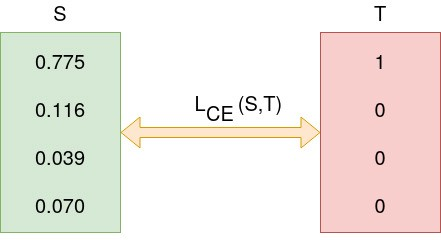

Cross-entropy loss is a measure of how far apart two probability distributions are from one another. Mathematically it is given by the following formula where $\mathcal{W}$ is the set of discrete outcomes of the probability distribution:

${H(p,q)=-\sum _{w\in {{W}}}p(w)\,\log q(w)} = -p \cdot log(q)$

Where $p$, $q$ are the probability mass functions. 

To apply this to neural networks we let $\vec{x_i}$ be the vector of inputs for sample i. Let $\vec{y_i}$ be the one hot encoded ground truth label corresponding to input $\vec{x_i}$. Lastly let $f(p, x)$ represent the neural network with parameters p (the weights and biases for each neuron), where the output is given as a column vector of probabilities of each class. Then we define the total loss as a function of the neural network parameters:

$Loss(p)= -\frac{1}{N}\sum_{i=0}^N \vec{y_i} \cdot \log(f(p, \vec{x_i}))$

Where N is the total number of training samples being considered, log operates elementwise, and the dot represents the dot product between two vectors. 

**Optimizer** 

In [ ]:
optimizer = torch.optim.Adam(network.get_params(), lr=0.005)

The optimizer is tasked in finding the optimal set of parameters p such that $Loss(p)$ is minimized. Because optimization is memory intensive and neural networks are often quite complex it is unfeasible to optimize the loss function defined above as is. We break the training set into smaller subsets called **batches** and minimize the loss of a particular batch each iteration. If the batch is randomly selected, balanced and large enough we can be sure that it is a good proxy to the loss function.  

The optimizer uses a gradient descent based method to find the optimal parameters. Gradient descent can be best understood in one dimension:


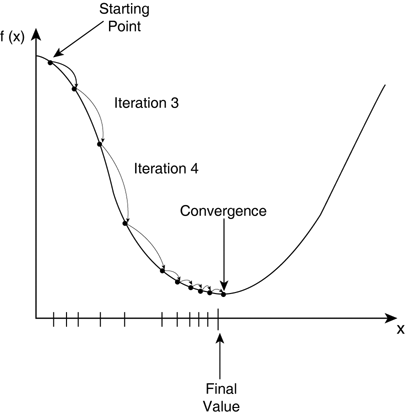

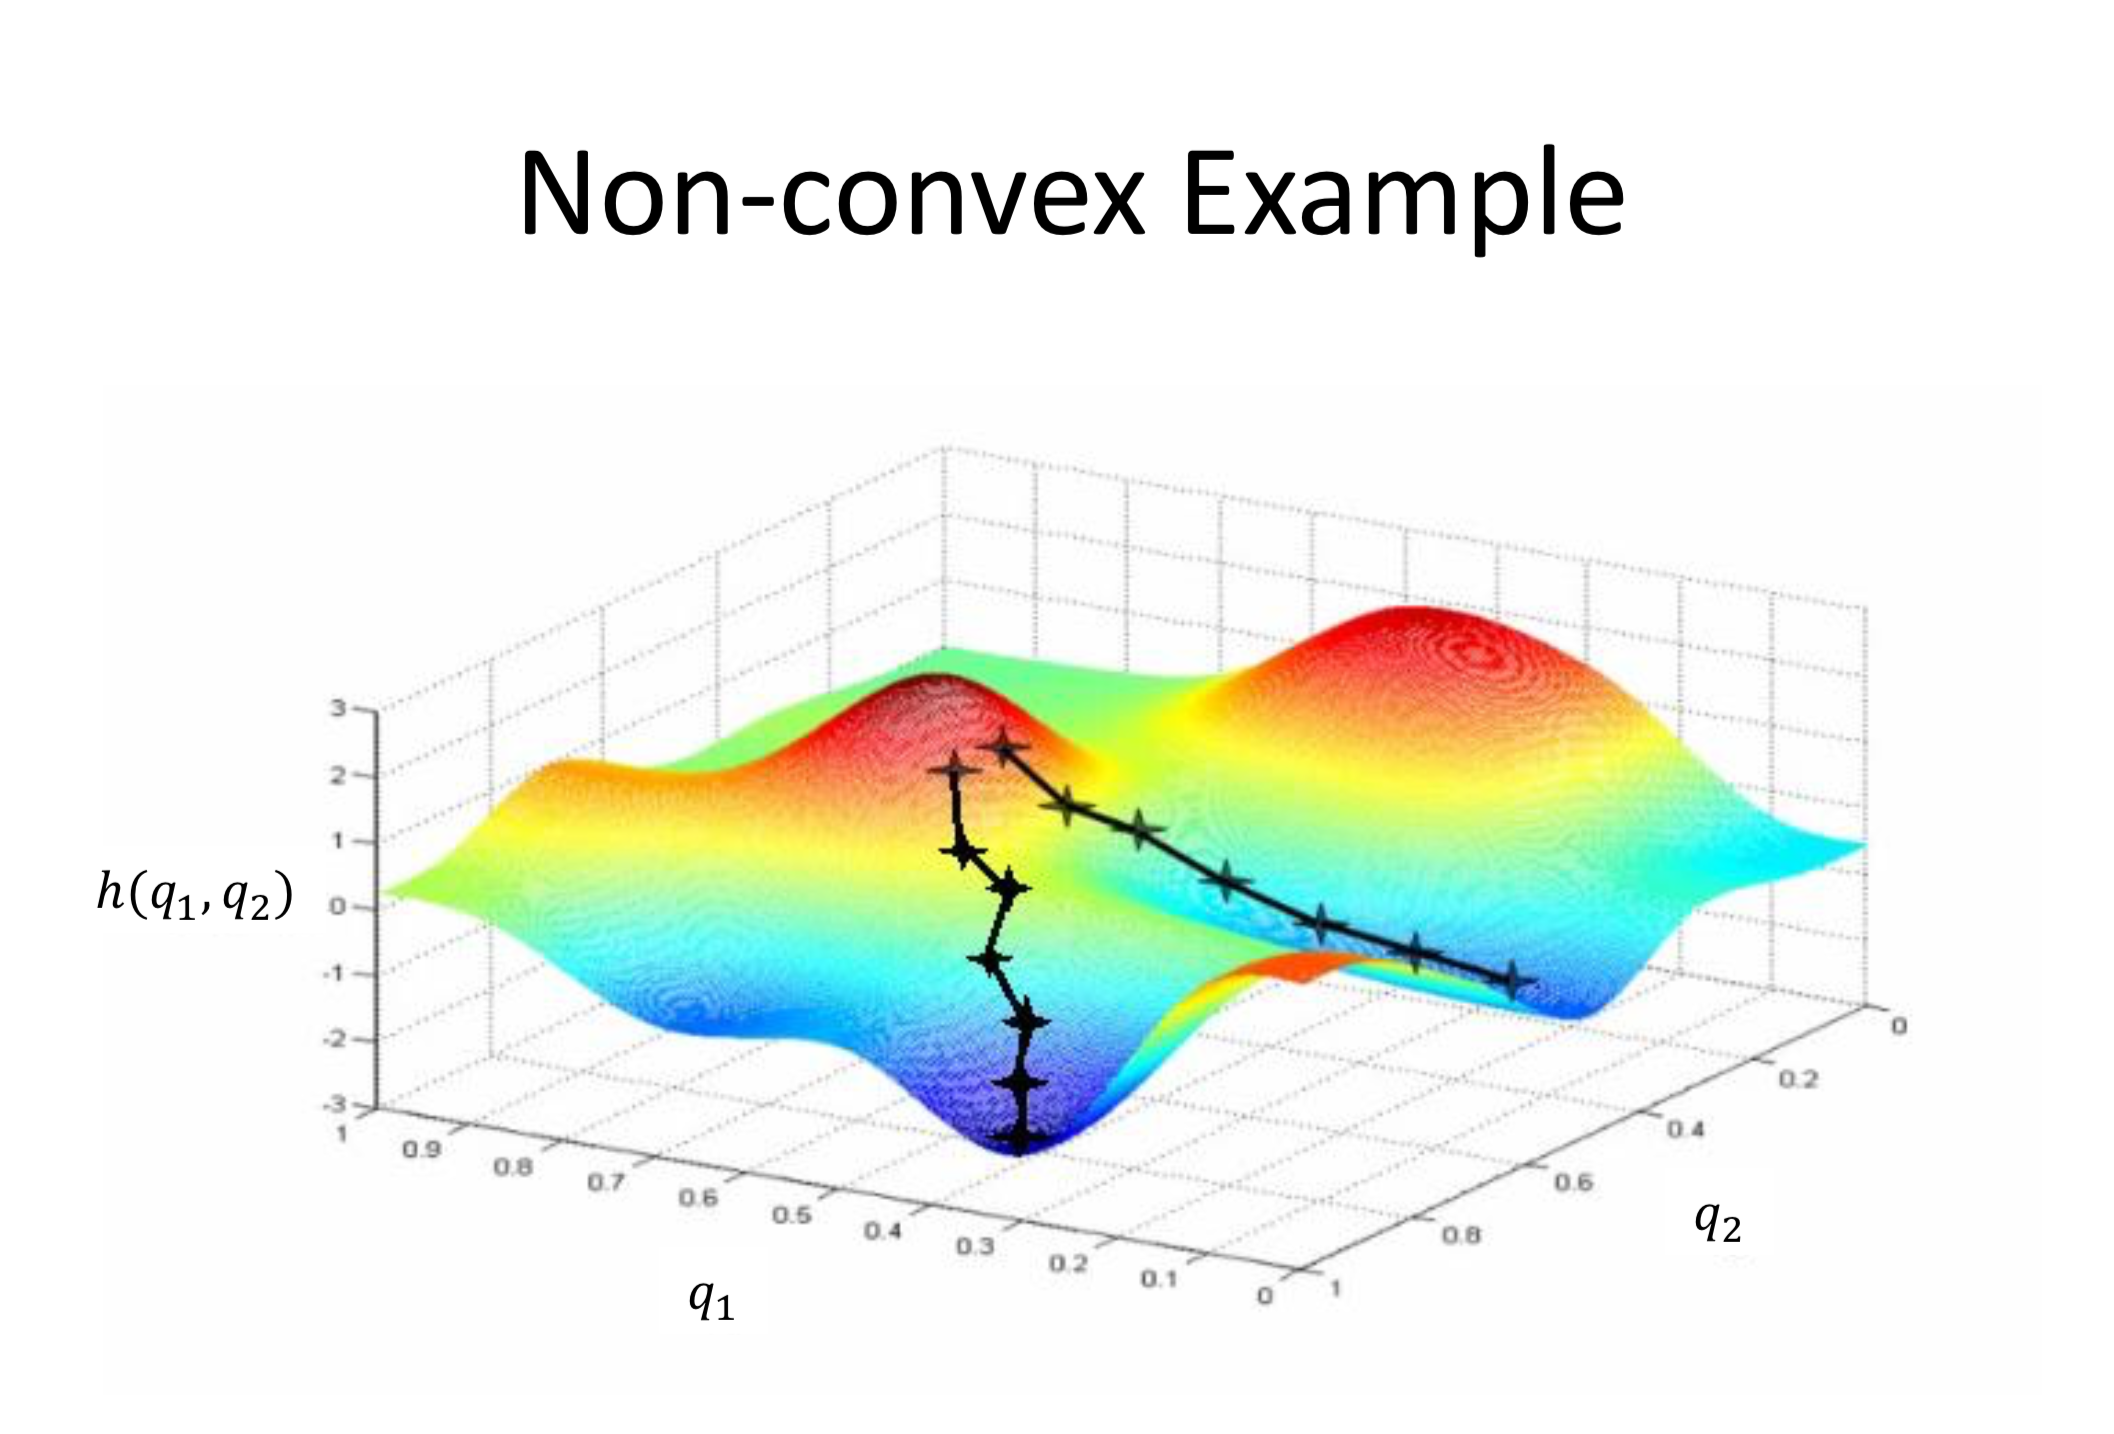

## The Training Loop

In [ ]:
for epoch in range(30):
    accuracy = 0
    epochLoss = 0
    print(epoch)
    for batch_x, batch_y in iter(trainloader):
        '''
        load in one batch of data
        '''
        batch_x = batch_x.reshape(batch_x.size()[0], 784)
        '''
        Run it through the neural network to get the predictions for each sample in the batch
        '''
        outputs = network.forward(batch_x)
        '''
        Loss function effectively computes the difference between the predicted label 
        and the actual label 
        '''
        loss = nn.functional.nll_loss(outputs, batch_y)
        
        '''
        This is a crucial pattern you will see in pytorch code. Optimizer.zero_grad()
        clears the gradients stored in all the tensors. This is important because 
        for technical reasons the autograd engine which computes all the partial 
        derivatives chooses to accumulate instead of rewrite the gradient values. 
        '''
        optimizer.zero_grad()

        '''
        This runs the autograd engine to compute partial derivatives of all network 
        parameters with respect to the loss function.
        '''
        loss.backward()
        '''
        The optimizer.step function uses the gradients computed in the previous step
        and then updates the parameters of all neurons in the neural network with values 
        that should lead to better network performance
        '''
        optimizer.step()

        epochLoss += loss.detach().numpy()
        prediction = torch.argmax(outputs, 1)
        currAccuracy = torch.sum((prediction == batch_y).type(torch.LongTensor))
        accuracy += currAccuracy.detach().numpy()
    print("current loss:", epochLoss / len(trainloader.dataset))
    accuracy = accuracy / len(trainloader.dataset)
    print("current accuracy:", accuracy)
    if accuracy > 0.97:
        break

## Lets Test the Network Now Using an Independent Test Set!

In [ ]:
accuracy = 0
loss = 0
for data, label in iter(testloader):
    data = data.reshape(data.size()[0], 784)
    prediction = torch.argmax(network.forward(data), 1)
    accuracy += torch.sum(prediction == label)
    loss += nn.functional.cross_entropy(network.forward(data), label)
loss = loss.detach().numpy() / len(testloader.dataset)
accuracy = accuracy.detach().numpy() / len(testloader.dataset)
print("Neural Network Test Loss", loss)
print("Test Accuracy",  accuracy)

 # Part 2: Building a Network using Pytorch Modules

First we handle the imports. torchvision is a part of the Pytorch library that contains pretrained models and datasets that are ready for use. torch.nn offers basic building blocks that simplify the functions we defined earlier.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Next we are going to preprocess the images from our dataset by defining a transform. We are using the CIFAR-10 dataset, which contains images of size 32x32. We normalize these images according to the dataset specifications (so the numbers below are not arbitrary).

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), # computed by others
])

We first download the CIFAR10 dataset using torchvision and transform the data using the transform defined above. This data is fed into a DataLoader, which handles operations on the data and the action of feeding the data into our model. We then define the class labels that will be used for the CIFAR-10 dataset.

In [ ]:
#Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

#Class labels

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

The code snippet below visualizes the transformed images we will be feeding into our model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


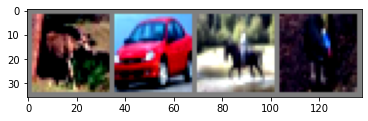

 Deer   Car Horse  Bird


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defining our Model with Sequential
We will now define our model using the torch.nn modules. 


In [ ]:
# We use the torch.nn library to add our layers
my_model = torch.nn.Sequential(
  torch.nn.Flatten(), # Flatten Images into 1-d Tensor
  # input to hidden 1
  torch.nn.Linear(in_features=3072, out_features=2048), # 32*32*3
  torch.nn.ReLU(2048),
  torch.nn.Dropout(0.2),

  # hidden 1 to hidden 2
  torch.nn.Linear(2048,1024),
  torch.nn.ReLU(1024),
  torch.nn.Dropout(0.2),

  # hidden 2 to hidden 3
  torch.nn.Linear(1024,512),
  torch.nn.ReLU(512),
  torch.nn.Dropout(0.2),

  # hidden 3 to output
  torch.nn.Linear(512,10),
  torch.nn.Softmax(dim=1)
)

# Model description
my_model.train()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=2048, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU(inplace=True)
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=1024, out_features=512, bias=True)
  (8): ReLU(inplace=True)
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=512, out_features=10, bias=True)
  (11): Softmax(dim=1)
)

In [ ]:
# For using the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Verifying CUDA device is available
print(device)

# If possible, moves training over to GPU/TPU. Otherwise defaults to CPU
my_model.to(device)

cpu


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=2048, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU(inplace=True)
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=1024, out_features=512, bias=True)
  (8): ReLU(inplace=True)
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=512, out_features=10, bias=True)
  (11): Softmax(dim=1)
)

We define our loss function as the Cross Entropy Loss (which is common for classification tasks) and use Stochastic Gradient Descent for our optimizer.

In [ ]:
import torch.optim as optim

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)

## (Optional) Training the Model
The code snippet below trains our model over 20 epochs. The runtime for this portion on Google Colab's GPUs still takes a significant amount of time, so we leave this script optional for your own interest.

In [ ]:
"""
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = my_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 6000 == 5999:    # print every 6000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 6000))
            running_loss = 0.0
            

print('Finished Training of Model')
"""

Instead we have trained the model with the script above and saved the weights for you to load.

## Loading in the Weights for our Model
We will download our pre-trained weights for the MLP into our Google Colab environment from a Github repository.

Github is a standard tool used by software developers and computer programmers of all types that makes it easy to share, update and keep track of code. It is used accross industry and academia for both personal and team-oriented projects.

The Github repository for this project, https://github.com/alexzhang13/PDS_Workshop_4_19_21, simply contains the weights for the network we defined above and a description of the model. It is imperative that the exact network is correct, or the weights will not work.

In [ ]:
# This is a code cell--we can execute Python code here.
!git clone https://github.com/alexzhang13/PDS_Workshop_4_19_21.git

In [ ]:
my_model.load_state_dict(torch.load('./PDS_Workshop_4_19_21/weights.pt', map_location=device))
# torch.save(my_model.state_dict(), "./weights.pt")

Finally, we test our trained model on the CIFAR-10 test set! 

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = my_model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print('Loss of network on the 10000 test images: %f' % (loss))